In [1]:
import sys, os
from time import time
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from modules.paths import Experiment
from modules.background import LinearCorrection, GLMCorrection, StackCorrector
from modules.io import IO

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Load paths to each set of experiments
loc = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/'
control_folder = 'control/stacks'
mutant_folder = 'perturbation/stacks'

paths = {
    'wt_clones_eye29_12_50': os.path.join(loc, control_folder, 'CONTROLS-NO-YanAllele_DAPI_w-eyFLP_PntGFP_FRT40A_PntGFP_Ubi-mR....lif - w-eyFLP_PntGFP_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_Disc29c.tif'),
    'wt_clones_eye31_12_50': os.path.join(loc, control_folder, 'CONTROLS-NO-YanAllele_DAPI_w-eyFLP_PntGFP_FRT40A_PntGFP_Ubi-mR....lif - w-eyFLP_PntGFP_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_Disc31c.tif'),
    'eye6_12_50': os.path.join(loc, mutant_folder, 'DAPI_w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_S...w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_Disc6b.tif'),
    'eye36_12_50': os.path.join(loc, mutant_folder, 'DAPI_w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_C...-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_Disc36e.tif'),
    'eye37_12_50': os.path.join(loc, mutant_folder, 'DAPI_w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_C...-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_Disc37e.tif'),
    'eye54': os.path.join(loc, mutant_folder, 'w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_Disc54b.tif')
}

disc_names = {29: 'wt_clones_eye29_12_50',
             31: 'wt_clones_eye31_12_50',
             6: 'eye6_12_50',
             36: 'eye36_12_50',
             37: 'eye37_12_50',
             54: 'eye54'}

layers = {29: [41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 54, 56],
     31: [29, 30, 32, 33, 37, 38, 40, 49],
 36: [19,20,29,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,51,52,53,54],
 37: [38, 40, 42, 43, 45, 46, 48],
 6: [44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 60, 62, 66],
 54: [27, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 49, 50, 51, 56, 57, 61]}

offsets = {29: 7,
          31: 1,
          6: 3,
          36: 0,
          37: 10,
          54: 0}

bits = {29: 2**12,
          31: 2**12,
          6: 2**12,
          36: 2**12,
          37: 2**12,
          54: 2**8}

# extract bg pixels

In [3]:
from modules.stacks import Stack
from modules.stack_correction import BackgroundExtraction, StackExtraction, OLS, GLM

In [6]:
niters = 25
for disc_id in offsets.keys():
    preprocessing_kws = {"median_radius": 2, "gaussian_sigma": [2, 2], "clip_limit": 0.03, "clip_factor": 20}
    annotated_layers = np.array(layers[disc_id]) - offsets[disc_id]
    stack_path = paths[disc_names[disc_id]]
    stack = Stack(stack_path, bits=bits[disc_id])
    extraction = StackExtraction(disc_id, stack, annotated_layers, niters=niters, **preprocessing_kws)

In [38]:
disc_id = 54
preprocessing_kws = {"median_radius": 2, "gaussian_sigma": [2, 2], "clip_limit": 0.03, "clip_factor": 20}
annotated_layers = np.array(layers[disc_id]) - offsets[disc_id]
stack_path = paths[disc_names[disc_id]]
stack = Stack(stack_path, bits=bits[disc_id])
extraction = StackExtraction(disc_id, stack, annotated_layers, niters=niters, **preprocessing_kws)

# Fit model to bg pixels

In [5]:
import glob
from modules.stack_correction import OLS, GLM

def load_bg_pixels(disc_bg_path):
    io = IO()
    layer_bg_paths = glob.glob(os.path.join(disc_bg_path, '*[0-9].json'))
    r, g = [], []
    for layer_bg_path in layer_bg_paths:
        pixels = io.read_json(layer_bg_path) 
        r.extend(pixels['r'])
        g.extend(pixels['g'])
    return np.array(r), np.array(g)

In [8]:
for disc_id in (6, 29, 31, 36, 37, 54):
    try:
        disc_bg_path = os.path.join('./stack_backgrounds', str(disc_id))
        r, g = load_bg_pixels(disc_bg_path)
        glm = GLM(r, g, resample=True, cutoff=99.99)
        glm.save(disc_bg_path)
    except Exception as e:
        print(disc_id)
        print(e)

In [6]:
disc_id = 54
disc_bg_path = os.path.join('./stack_backgrounds', str(disc_id))
r, g = load_bg_pixels(disc_bg_path)
glm = GLM(r, g, resample=True, cutoff=99.99)
glm.save(disc_bg_path)

# individual discs

In [8]:
io = IO()
pts = io.read_json('./stack_backgrounds/pts.json')

In [10]:
def plot_correction(glm, x, y):
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(8, 3))
    ax0.scatter(x, y, c='k', s=3)
    xx = np.linspace(x.min(), x.max(), 10)
    ax0.plot(xx, glm.predict(xx), '-r')    
    yp = glm.predict(x)
    ax1.scatter(x, y-yp, c='k', s=3)
    ax0.set_ylim(-0.2, 0.8)

# single layer

In [40]:
disc_id = 54
layer_id = 0

annotated_layers = np.array(layers[disc_id]) - offsets[disc_id]
stack_path = paths[disc_names[disc_id]]
#stack = Stack(stack_path)
layer = stack.get_layer(annotated_layers[layer_id])

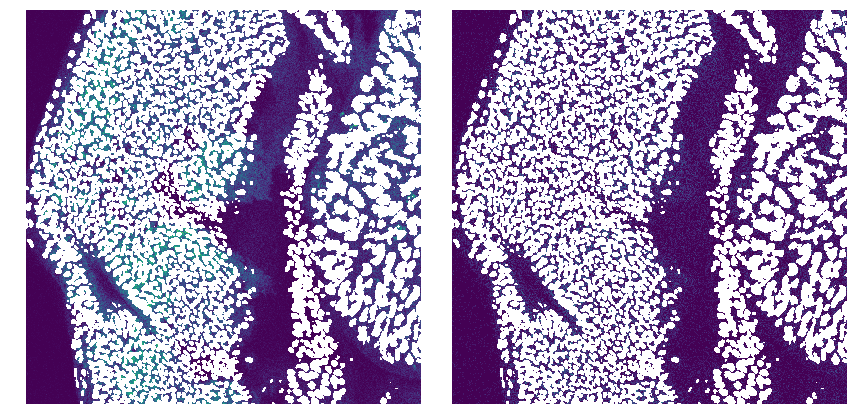

In [41]:
niters = 1
ext = BackgroundExtraction(layer, niters, **preprocessing_kws)
_ = ext.show_mask()

In [70]:
disc_id = 37

# pixel extraction
niters = 40
preprocessing_kws = {"median_radius": 2, "gaussian_sigma": [2, 2], "clip_limit": 0.03, "clip_factor": 20}
annotated_layers = np.array(layers[disc_id]) - offsets[disc_id]
stack_path = paths[disc_names[disc_id]]
stack = Stack(stack_path)
extraction = StackExtraction(disc_id, stack, annotated_layers, niters=niters, **preprocessing_kws)

In [71]:
# model fitting
disc_bg_path = os.path.join('./stack_backgrounds', str(disc_id))
bg_r, bg_g = load_bg_pixels(disc_bg_path)
glm = GLM(bg_r, bg_g, resample=True, cutoff=99.99)
glm.save(disc_bg_path)

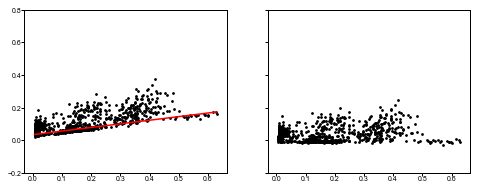

In [11]:
x, y = np.array(pts[str(disc_id)]['r']), np.array(pts[str(disc_id)]['g'])
plot_correction(glm, x, y)

In [73]:
glm.save(disc_bg_path)

In [3]:
import tifffile as tf

In [4]:
loc

NameError: name 'loc' is not defined

In [11]:
loc = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/mutants_silhouette/clones/Disc54'

In [13]:
from glob import glob

In [15]:
files = glob(os.path.join(loc, '*[0-9].tif'))
im = tf.imread(files)

In [58]:
im_reshaped = np.swapaxes(np.swapaxes(im[:,:,:,::-1], -2, -1), -3, -2).astype(np.uint16)

In [57]:
loc = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/'
mutant_folder = 'perturbation/stacks'

p = os.path.join(loc, mutant_folder, 'w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_Disc54b.tif')

In [59]:
tf.imsave(p, data=im_reshaped)

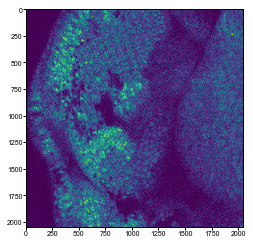

In [56]:
_ = plt.imshow(im_reshaped[20][2])

In [29]:
loc = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/perturbation/stacks/DAPI_w-eyFLP_PntGFP_YanE833_FRT40A_Ubi-mRFPnls_FRT40A_Cross_5B...m.lif - w-eyFLP_PntGFP_YanE833_FRT40_Ubi-mRFPnls_FRT40A_Disc1e.tif'

In [30]:
im2 = tf.imread(loc)

In [32]:
im2.shape

(60, 3, 2048, 2048)

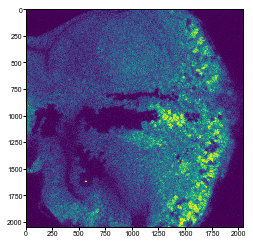

In [42]:
plt.imshow(im2[20][2])